In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas as pd

In [2]:
tckrs = ["ADBE", "AMAT", "AMZN", "BRK-B", "DAL", "GOOG", "MCD"]

In [3]:
start = "2020-01-18"
end = "2021-11-01"
lookahead = 5

In [4]:
dates = pd.date_range(start, end)

In [5]:
base = "/home/greg_b/voltron/experiments/trading/saved-outputs/"

In [6]:
full_predictions = []
has_dates = []
for date in dates:
    cap = str(date)[:10]
    try:
        predictions = torch.stack([torch.load(base + tckr + "/volt_ewma200_"+cap+".pt") for tckr in tckrs])
        full_predictions.append(predictions)
        has_dates.append(cap)
    except:
        print(cap)

2020-01-18
2020-01-19
2020-01-20
2020-01-25
2020-01-26
2020-02-01
2020-02-02
2020-02-08
2020-02-09
2020-02-15
2020-02-16
2020-02-17
2020-02-22
2020-02-23
2020-02-29
2020-03-01
2020-03-07
2020-03-08
2020-03-14
2020-03-15
2020-03-21
2020-03-22
2020-03-28
2020-03-29
2020-04-04
2020-04-05
2020-04-10
2020-04-11
2020-04-12
2020-04-18
2020-04-19
2020-04-25
2020-04-26
2020-05-02
2020-05-03
2020-05-09
2020-05-10
2020-05-16
2020-05-17
2020-05-23
2020-05-24
2020-05-25
2020-05-30
2020-05-31
2020-06-06
2020-06-07
2020-06-13
2020-06-14
2020-06-20
2020-06-21
2020-06-27
2020-06-28
2020-07-03
2020-07-04
2020-07-05
2020-07-11
2020-07-12
2020-07-18
2020-07-19
2020-07-25
2020-07-26
2020-08-01
2020-08-02
2020-08-08
2020-08-09
2020-08-15
2020-08-16
2020-08-22
2020-08-23
2020-08-29
2020-08-30
2020-09-05
2020-09-06
2020-09-07
2020-09-12
2020-09-13
2020-09-19
2020-09-20
2020-09-26
2020-09-27
2020-10-03
2020-10-04
2020-10-10
2020-10-11
2020-10-17
2020-10-18
2020-10-24
2020-10-25
2020-10-31
2020-11-01
2020-11-07

In [7]:
daily_predictions = torch.stack(full_predictions)

In [8]:
daily_predictions.shape

torch.Size([451, 7, 1000, 20])

In [9]:
from pandas.tseries.holiday import USFederalHolidayCalendar


In [10]:
date

Timestamp('2021-11-01 00:00:00', freq='D')

In [11]:
bday_us = pd.offsets.CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [12]:
end_plus_20 = str(pd.date_range(start=end, periods=21, freq=bday_us)[-1])[:10]

In [13]:
observations = torch.tensor(
    [yf.download(tckr, start=start, end=end_plus_20).Close.values for tckr in tckrs]
)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_42829/2183553156.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/torch/csrc/utils/tensor_new.cpp:201.)
  observations = torch.tensor(


In [14]:
idcs = torch.arange(0, daily_predictions.shape[0] - lookahead, lookahead)

In [15]:
returns = (observations[..., idcs+lookahead] / observations[..., idcs])

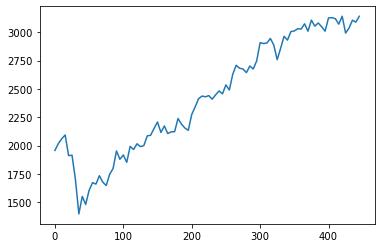

In [16]:
plt.plot(idcs, returns.mean(0).cumprod(0) * 2000)

In [17]:
daily_predictions.shape

torch.Size([451, 7, 1000, 20])

In [18]:
num_obs = daily_predictions.shape[0]

In [19]:
tenday_lookahead = daily_predictions[..., lookahead].permute(1, 2, 0)

In [20]:
exp_means = tenday_lookahead.exp().mean(1)
exp_stds = tenday_lookahead.exp().std(1)

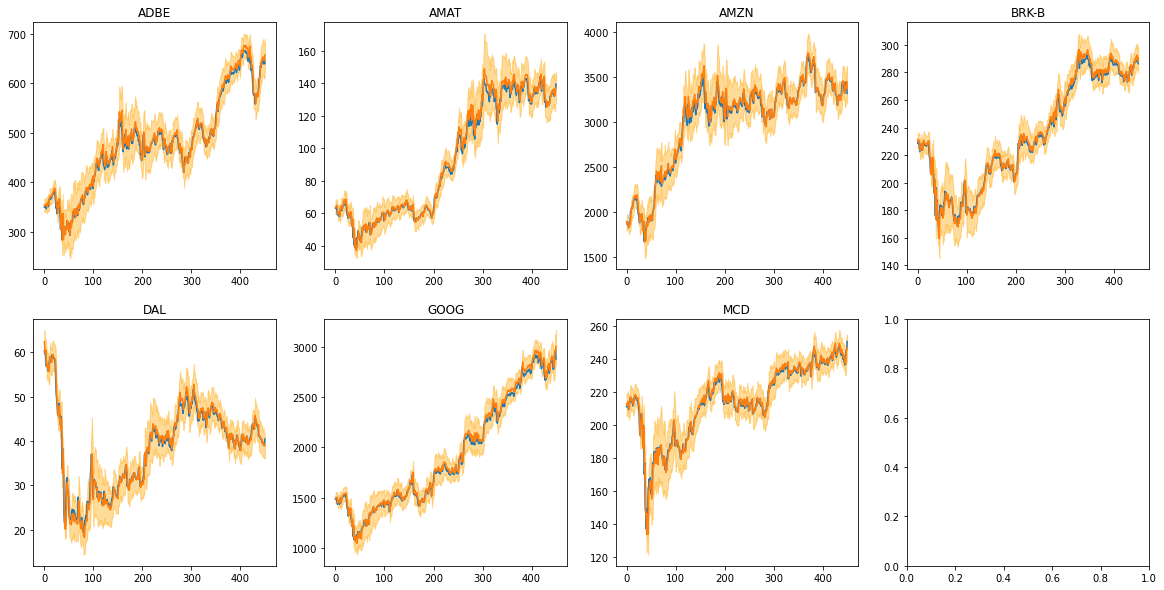

In [21]:
fig, ax = plt.subplots(2, 4, figsize = (20, 10))
ax = ax.reshape(-1)

for i in range(7):
    # ax[i].plot(torch.arange(-lookahead, -lookahead+num_obs+22), observations[i])
    ax[i].plot(observations[i, :-20])
    ax[i].plot(exp_means[i])
    ax[i].fill_between(
        torch.arange(num_obs), 
        (exp_means - 2 * exp_stds)[i],
        (exp_means + 2 * exp_stds)[i],
        alpha = 0.4, 
        color = "orange"
    )
    ax[i].set_title(tckrs[i])

In [22]:
returns_for_cov = (observations[..., lookahead:] - observations[..., :-lookahead]) \
    / observations[..., :-lookahead]

In [23]:
returns_for_cov.shape

torch.Size([7, 466])

In [24]:
lookahead_price = tenday_lookahead.exp()

In [25]:
lookahead_price.shape

torch.Size([7, 1000, 451])

In [26]:
returns_from_preds = (lookahead_price[..., lookahead:] - lookahead_price[..., :-lookahead]) \
    / lookahead_price[..., :-lookahead]

In [27]:
lookahead_price[..., lookahead:].shape

torch.Size([7, 1000, 446])

In [28]:
returns_from_obs = (lookahead_price[..., lookahead:] - observations[..., :-(lookahead+20)].unsqueeze(-2)) \
    / observations[..., :-(lookahead+20)].unsqueeze(-2)

In [29]:
returns_from_preds.shape

torch.Size([7, 1000, 446])

Text(0.5, 0.98, 'Predicted vs Actual Returns')

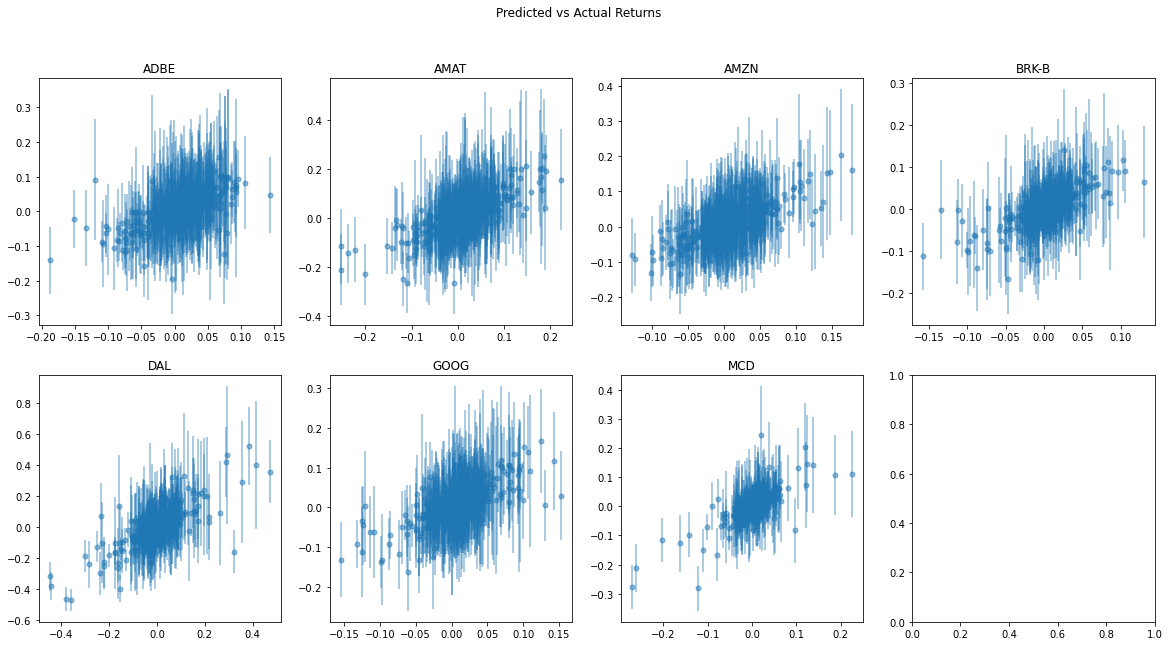

In [30]:
fig, ax = plt.subplots(2, 4, figsize = (20, 10))
ax = ax.reshape(-1)

for i in range(7):
    # ax[i].plot(torch.arange(-lookahead, -lookahead+num_obs+22), observations[i])
    ax[i].errorbar(returns_for_cov[i, :-20], returns_from_preds[i].mean(0), 
                   yerr=returns_from_preds[i].std(0) * 2., ls = "none",
                  marker = ".", markersize = 10, alpha = 0.5)
    ax[i].set_title(tckrs[i])
fig.suptitle("Predicted vs Actual Returns")

Text(0.5, 0.98, 'Observed vs Actual Returns')

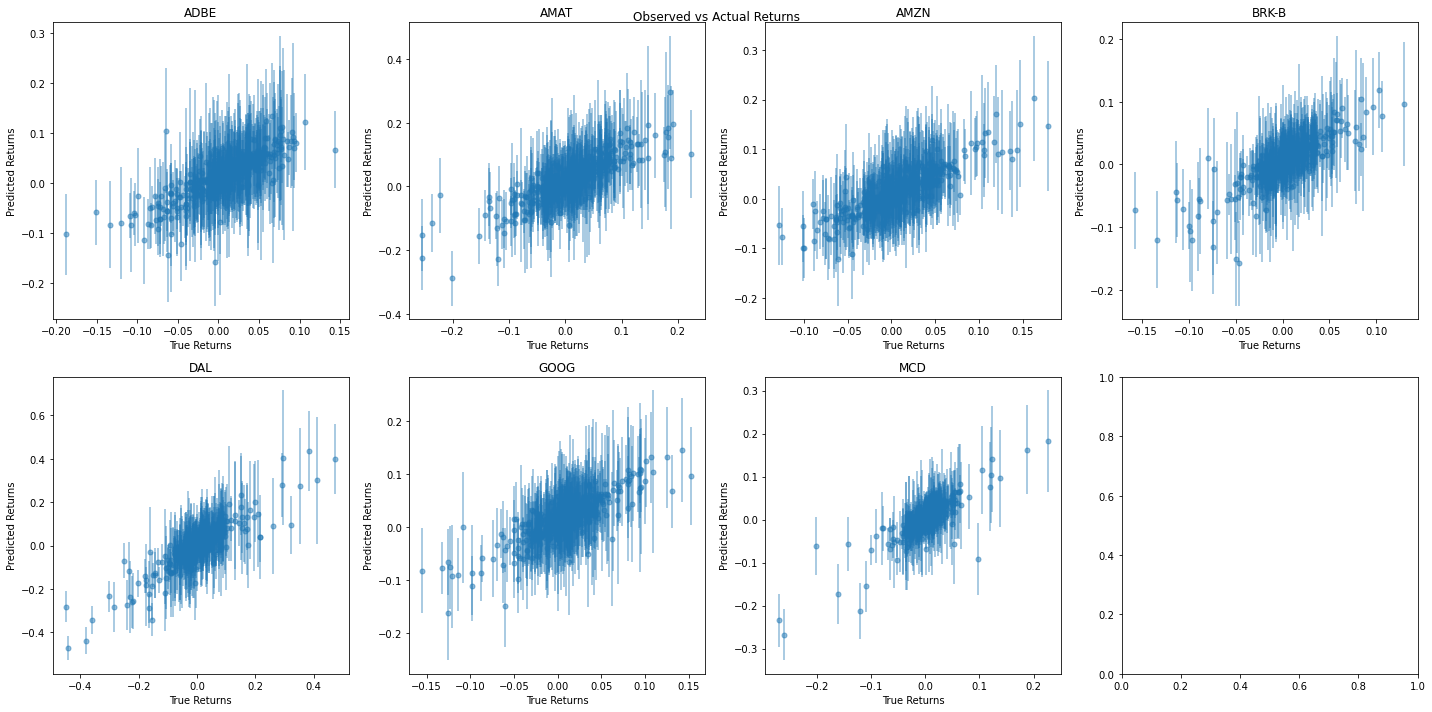

In [31]:
fig, ax = plt.subplots(2, 4, figsize = (20, 10))
ax = ax.reshape(-1)

for i in range(7):
    # ax[i].plot(torch.arange(-lookahead, -lookahead+num_obs+22), observations[i])
    ax[i].errorbar(returns_for_cov[i, :-20], returns_from_obs[i].mean(0), 
                   yerr=returns_from_obs[i].std(0) * 2., ls = "none",
                  marker = ".", markersize = 10, alpha = 0.5)
    ax[i].set_title(tckrs[i])
    ax[i].set_xlabel("True Returns")
    ax[i].set_ylabel("Predicted Returns")
plt.tight_layout()
fig.suptitle("Observed vs Actual Returns")

In [32]:
excess_returns = returns_from_obs - lookahead / 252 * 0.03

In [33]:
mean_excess_returns = excess_returns.mean(1)

In [34]:
cov_excess_returns = torch.stack([torch.cov(excess_returns[..., i]) for i in range(excess_returns.shape[-1])])

In [35]:
opt_excess_returns = returns_for_cov - lookahead / 252 * 0.03
cov_opt_excess_returns = torch.stack(
    [torch.cov(opt_excess_returns[..., :i]) for i in range(opt_excess_returns.shape[-1])]
)

/tmp/ipykernel_42829/1267487358.py:3: UserWarning: cov(): degrees of freedom is <= 0 (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/Correlation.cpp:99.)
  [torch.cov(opt_excess_returns[..., :i]) for i in range(opt_excess_returns.shape[-1])]


In [36]:
cov_opt_excess_returns[0:2] = cov_opt_excess_returns[2]

In [37]:
def compute_strategy(excess_returns, cov_est=None, normalize = False):
    if cov_est is None:
        batched_covs = torch.stack([torch.cov(excess_returns[..., i]) for i in range(excess_returns.shape[-1])])
    else:
        batched_covs = cov_est
    # expected_returns = excess_returns.mean(1)
    
    weights = torch.solve(excess_returns.t().unsqueeze(-1), batched_covs)[0]
    norm_constant = excess_returns.t().unsqueeze(-2).matmul(weights).sum(-1)
    res = weights.squeeze(-1) / norm_constant
    if normalize:
        res = res / res.abs().sum(1,keepdim=True)
    return res
    

In [83]:
weights = compute_strategy(mean_excess_returns, cov_opt_excess_returns[:-20], normalize=False) / (252 / 5)

In [84]:
opt_weights = compute_strategy(opt_excess_returns, cov_opt_excess_returns, normalize=False) / (252 / 5)

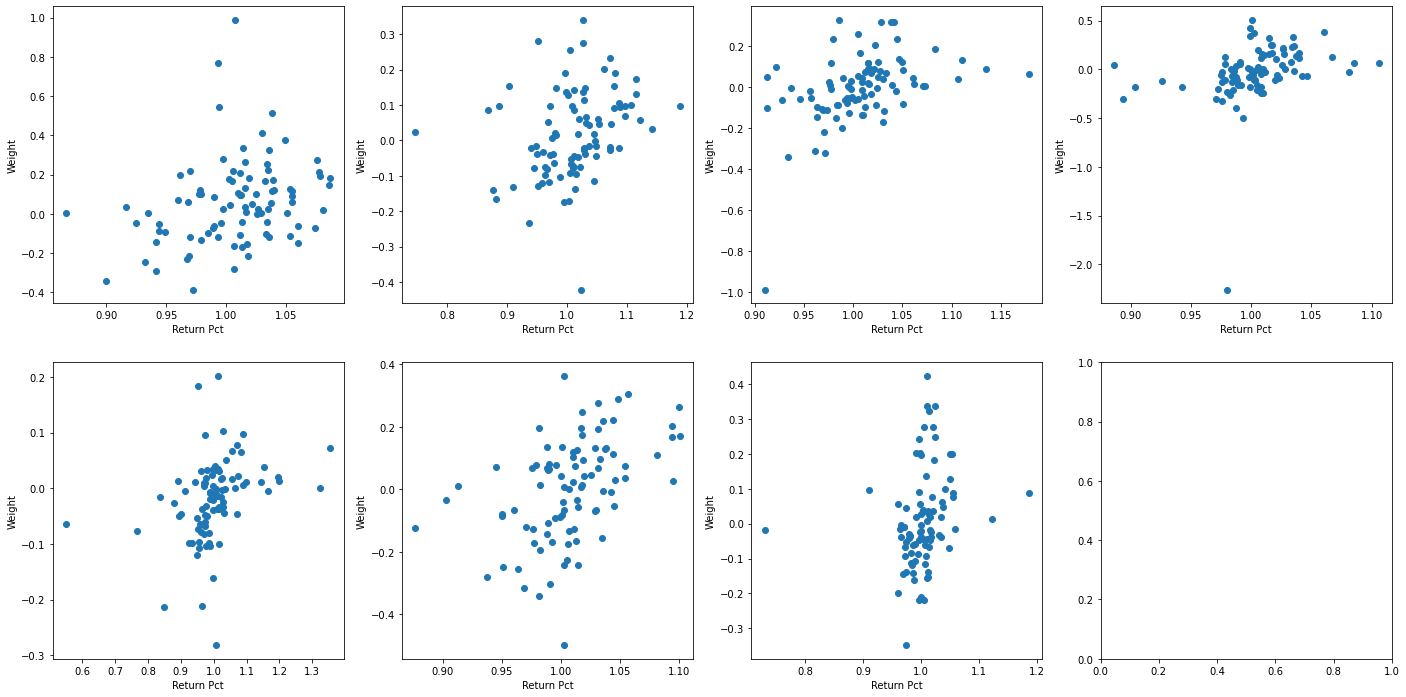

In [85]:
fig, ax = plt.subplots(2, 4, figsize = (24, 12))
ax = ax.reshape(-1)

for i in range(7):
    ax[i].scatter(returns[i, :], weights[idcs, i], label = "Volt")
    # ax[i].scatter(returns_for_cov[i, :-20], opt_weights[:-20, i])
    ax[i].set_xlabel("Return Pct")
    ax[i].set_ylabel("Weight")

In [86]:
5/252 * 0.03

0.0005952380952380952

In [87]:
weights[idcs].clamp(min=0).sum(1)

tensor([0.7768, 0.4056, 1.3089, 0.6419, 0.1949, 0.3548, 0.2843, 0.1226, 0.2757,
        0.4165, 0.2120, 0.2588, 0.4508, 0.4033, 0.1330, 0.3146, 0.3804, 0.4811,
        0.1707, 0.1550, 0.3644, 0.4446, 0.3689, 0.3505, 0.4387, 0.4311, 0.3544,
        0.4135, 0.6409, 0.2375, 0.2774, 0.5695, 0.3388, 0.3125, 0.8466, 0.6942,
        0.2655, 0.4590, 0.3974, 0.2015, 0.1729, 0.4132, 0.1892, 0.4325, 0.3350,
        0.5971, 0.5052, 0.5698, 0.1684, 0.1322, 0.2550, 0.3162, 0.1859, 0.2422,
        0.2669, 0.3305, 0.2241, 0.2932, 0.5284, 0.3609, 0.2392, 0.5590, 0.5397,
        1.1050, 0.3564, 0.7277, 0.4978, 0.2653, 0.5850, 0.4756, 1.2329, 0.4075,
        0.5963, 0.2604, 0.5769, 0.3745, 1.5866, 0.5317, 0.3394, 0.4622, 0.4980,
        0.7029, 0.8258, 0.8419, 0.4071, 0.1742, 0.4022, 0.4097, 0.3499, 0.2979],
       dtype=torch.float64)

In [88]:
renorm_pos_weights = weights
abs_pos_weights = weights.clamp(min=0.).sum(1)
renorm_pos_weights[abs_pos_weights > 1] /= abs_pos_weights[abs_pos_weights > 1].unsqueeze(-1)

In [106]:
renorm_cum_returns = (1 + (renorm_pos_weights[idcs] * (returns.t() - 1)).sum(1))#.cumprod(0)
weights_cum_returns = ((returns.t() - (weights[idcs] < 0) * 2.) * weights[idcs])#.cumprod(0)

In [107]:
(returns.t() * renorm_pos_weights[idcs]).sum(1).add(-5/252).cumprod(0)

tensor([ -1.5754e+00,   1.5114e-01,   4.5676e-02,   1.1528e-02,  -3.8191e-03,
          5.5698e-04,  -9.4058e-05,  -1.0462e-06,   1.8180e-08,   1.3373e-09,
          5.4753e-11,   1.7368e-12,  -1.5397e-13,   4.0236e-15,  -2.3957e-16,
          2.3922e-17,   1.4829e-18,   2.5690e-19,  -6.5382e-21,   3.5123e-22,
         -6.4241e-24,  -1.2097e-24,  -8.9138e-26,  -1.2346e-26,  -1.8663e-27,
         -1.5614e-28,  -7.0322e-30,  -1.2227e-30,  -6.0436e-32,  -6.2849e-33,
         -6.3108e-34,   2.1249e-34,   1.1093e-35,  -5.6801e-37,  -2.2420e-38,
         -2.6235e-39,  -2.7865e-40,   4.3239e-41,  -1.8599e-43,   8.7862e-45,
          5.9078e-47,   6.9101e-48,  -8.3512e-49,  -2.3769e-50,   2.2353e-51,
         -7.3985e-53,  -6.3117e-54,  -6.2106e-55,   2.8514e-56,  -1.7205e-57,
         -6.6171e-59,   1.0465e-59,   4.1975e-61,   1.0871e-62,  -1.2365e-63,
         -1.4619e-65,  -3.2951e-67,   1.1765e-68,   1.0288e-69,   7.2856e-71,
          5.5681e-72,   1.6389e-72,   3.4172e-73,   2.2113e-73, 

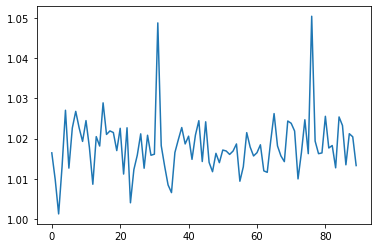

In [111]:
plt.plot(renorm_cum_returns)

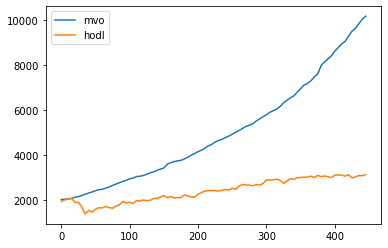

In [110]:
plt.plot(idcs, 2000 * renorm_cum_returns.cumprod(0), label = "mvo")
# plt.plot(idcs, 2000 * weights_cum_returns.cumprod(0),
#         label = "volt w/ shorts")
plt.plot(idcs, returns.mean(0).cumprod(0) * 2000, label = "hodl")
plt.legend()


(0.9, 1.1)

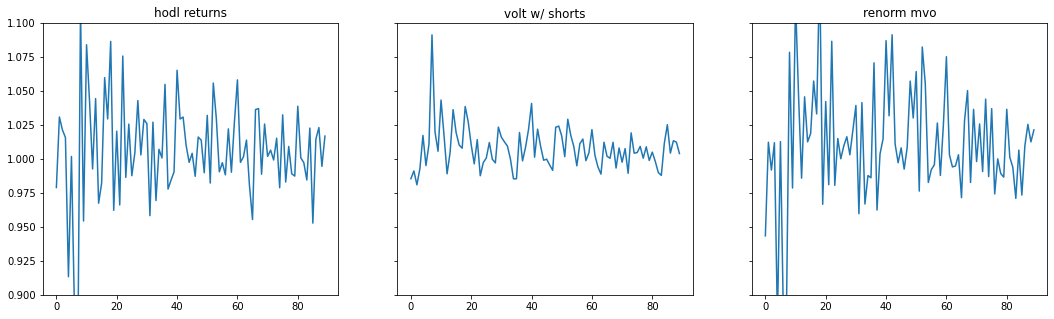

In [158]:
fig, ax = plt.subplots(1, 3, figsize = (18, 5), sharey=True)
ax[0].plot(returns.mean(0))
ax[0].set_title("hodl returns")

ax[1].plot(weights_cum_returns - 5/252)
ax[1].set_title("volt w/ shorts")

ax[2].plot(renorm_cum_returns - 5/252)
ax[2].set_title("renorm mvo")

ax[1].set_ylim((0.9, 1.1))

(0.95, 1.1)

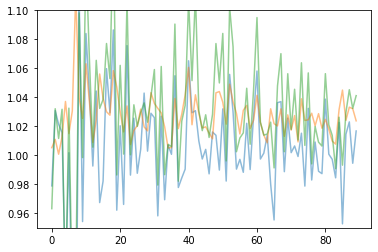

In [152]:
plt.plot(returns.mean(0), label = "hodl", alpha = 0.5)
plt.plot(weights_cum_returns, label = "volt w/ shorts", alpha = 0.5)
plt.plot(renorm_cum_returns, label = "renorm mvo", alpha = 0.5)
plt.ylim((0.95, 1.1))

In [76]:
((returns.t() + 2. * weights[idcs].clamp(min=0.).sign()) * weights[idcs].abs()).sum(1)#.cumprod(0)

tensor([1.8321, 1.7070, 1.7480, 1.8650, 1.6266, 2.1333, 2.3966, 1.8426, 1.8967,
        2.3337, 2.4437, 2.4170, 2.1036, 2.1973, 2.1029, 1.8264, 2.2410, 2.1255,
        1.9304, 2.1794, 1.7672, 2.1204, 2.3794, 2.4629, 1.8949, 2.7413, 1.9343,
        2.3057, 2.2768, 1.9762, 1.9844, 2.1707, 2.1963, 1.9611, 2.1281, 1.8099,
        2.2316, 2.2173, 2.1464], dtype=torch.float64)

In [38]:
compute_pct_returns = lambda w: ((w * returns_for_cov[..., :-20]).sum(0)).cumsum(0)

In [42]:
nw = torch.ones_like(weights) / 7

In [43]:
nw.shape

torch.Size([195, 7])

In [44]:
raw_returns = (observations[..., lookahead:] - observations[..., :-lookahead])

In [47]:
value_at_time_curr = observations[..., :-lookahead].t()
value_at_time_next = observations[..., lookahead:].t()

In [74]:
valuation = torch.zeros(nw.shape[0]+1)
valuation[0] = 2000

for i in range(1, 5):
    cash_proportion = nw[i-1] * valuation[i-1]
    num_stocks = cash_proportion / value_at_time_curr[i]
    new_valuation = num_stocks * value_at_time_next[i]
    print(new_valuation)
    valuation[i] = new_valuation.sum()

tensor([279.7960, 261.1806, 283.0177, 276.7081, 264.4333, 277.2181, 276.8471],
       dtype=torch.float64)
tensor([270.4832, 256.8533, 268.4204, 270.4131, 270.1942, 270.0922, 265.5560],
       dtype=torch.float64)
tensor([259.6923, 243.1596, 260.4420, 261.6321, 253.7914, 258.2428, 260.4870],
       dtype=torch.float64)
tensor([254.9124, 240.3674, 260.5885, 252.7118, 249.6491, 257.0418, 250.2666],
       dtype=torch.float64)


In [76]:
valuation[0]

tensor(2000.)

In [78]:
nw[0] * valuation[0] / value_at_time_curr[0] * value_at_time_next[0]

tensor([298.0942, 276.0614, 304.5165, 282.0842, 278.6972, 305.8770, 294.3094],
       dtype=torch.float64)

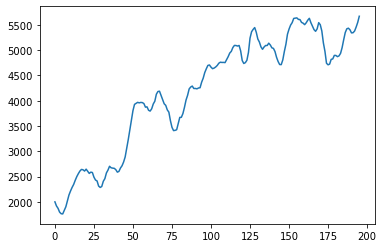

In [63]:
plt.plot(valuation)

In [90]:
weights.clamp(min=0.).sum(0)

tensor([19.4219,  8.8132, 11.4936, 23.5672,  5.9394, 19.9510, 17.8822],
       dtype=torch.float64)

In [92]:
weights.clamp(min=0.) / weights.clamp(min=0.).sum(1,keepdim=True)

tensor([[0.3360, 0.0000, 0.4734,  ..., 0.0000, 0.0000, 0.1906],
        [0.3034, 0.0371, 0.4418,  ..., 0.0000, 0.0000, 0.2176],
        [0.4157, 0.0000, 0.5122,  ..., 0.0000, 0.0720, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.8158, 0.1842],
        [0.0000, 0.0258, 0.0021,  ..., 0.0000, 0.6410, 0.3311],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.6742, 0.3258]],
       dtype=torch.float64)

In [114]:
weights.shape

torch.Size([195, 7])

In [115]:
idcs = torch.arange(0, weights.shape[0], 5)

In [116]:
idcs

tensor([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
         70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135,
        140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190])

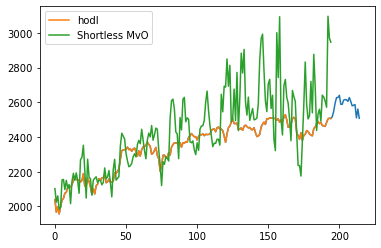

In [95]:
plt.plot((2000 / 7 / value_at_time_curr[0] * value_at_time_next).sum(1))
plt.plot((2000 * nw / value_at_time_curr[0] * value_at_time_next[:-20]).sum(1), label = "hodl")
plt.plot((2000 * weights.clamp(min=0.) / weights.clamp(min=0.).sum(1,keepdim=True) / \
          value_at_time_curr[0] * value_at_time_next[:-20]).sum(1), label = "Shortless MvO")
plt.legend()

In [81]:
nw.shape

torch.Size([195, 7])

In [97]:
value_mvo = (2000 * weights.clamp(min=0.) / weights.clamp(min=0.).sum(1,keepdim=True) / \
          value_at_time_curr[0] * value_at_time_next[:-20]).sum(1)

In [98]:
value_mvo[100:110]

tensor([2366.5299, 2323.2260, 2445.3728, 2463.2972, 2464.5993, 2494.4806,
        2600.8340, 2664.3831, 2552.9463, 2466.9879], dtype=torch.float64)

In [117]:
norm_pos_weights = weights.clamp(min=0.) / weights.clamp(min=0.).sum(1,keepdim=True)
norm_pos_weights = norm_pos_weights[idcs]

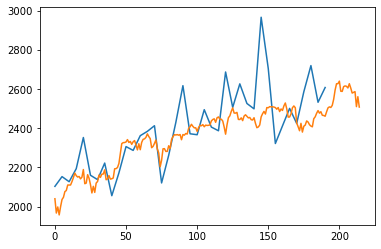

In [125]:
plt.plot(idcs, 2000 * (norm_pos_weights * value_at_time_next[idcs] / value_at_time_curr[0]).sum(1))
plt.plot((2000 / 7 / value_at_time_curr[0] * value_at_time_next).sum(1))

Text(0.5, 1.0, 'returns')

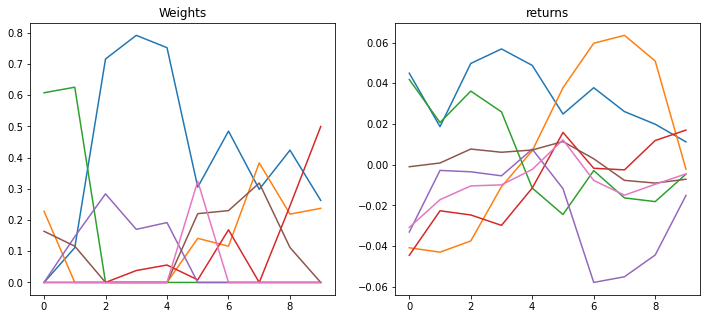

In [112]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(norm_pos_weights[100:110])
ax[1].plot(returns_for_cov[:, 100:110].t())
ax[0].set_title("Weights")
ax[1].set_title("returns")

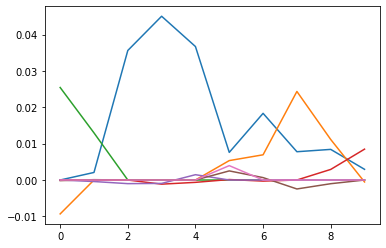

In [113]:
plt.plot(norm_pos_weights[100:110] * returns_for_cov[:, 100:110].t())